In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
# import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import models, regularizers, layers, optimizers, losses, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.1.0
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [2]:
file_dir = os.path.abspath('')
data1_path = os.path.join(file_dir, 'data1.csv')

with open(data1_path) as f:
    data = [i.strip().rsplit(',', maxsplit=1) for i in f.readlines()]

# ensure data is correctly loaded.
for item in data:
    if len(item) != 2:
        print(item)
    if item[-1] not in ['bad', 'good']:
        print(item)

In [3]:
df = pd.DataFrame(data)
df.columns = ['url', 'readable_label']
df = df.dropna()
df.head()

,url,readable_label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad


In [4]:
df['label'] = (df['readable_label'] == 'bad')

In [5]:
df = shuffle(df)

In [6]:
df.head(20)

,url,readable_label,label
97181,genforum.genealogy.com/reilly/,good,False
41612,stantonchase.com.tr/NEW/Google/index.php.htm,bad,True
171376,absoluteastronomy.com/topics/Crispus_Attucks,good,False
80365,en.wikipedia.org/wiki/Joel_Zifkin,good,False
130575,people.famouswhy.com/kimberly_patton/,good,False
311830,nytimes.com/1997/08/06/us/clarence-m-kelley-di...,good,False
206653,chacha.com/question/what-is-a-mayor-council-go...,good,False
103517,ico-nuclear-industry.com/,good,False
94505,freepages.genealogy.rootsweb.ancestry.com/~cha...,good,False
273549,kutt.com/events,good,False


In [7]:
df['label'].value_counts()

False    344821
True      75643
Name: label, dtype: int64

In [8]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))

train count: 206026, valid count: 88298, test count: 126140


In [9]:
df[len(train_idx): len(train_idx)+len(valid_idx)]['label'].value_counts()

False    72501
True     15797
Name: label, dtype: int64

In [10]:
int2label = {
    False: 'good',
    True: 'bad',
}

In [11]:
from tensorflow.keras.utils import to_categorical


def get_data_generator(df, indices, for_training, batch_size=16):
    urls, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            url, label = r['url'], r['label']
            urls.append(url)
            labels.append(label)
            if len(urls) >= batch_size:
#                 print(np.array(urls), np.array(labels))
                yield np.array(urls), np.array(labels)
                urls, labels = [], []
        if not for_training:
            break

In [12]:
os.environ["TFHUB_CACHE_DIR"] = os.path.join(os.path.expanduser('~'), '.tfhub-cache')

In [13]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
# hub_layer(train_examples_batch[:3])

In [14]:
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

In [15]:
embed(["cat is on the mat", "dog is in the fog"])

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 0.8666395 ,  0.35917717,  0.00579667,  0.681002  , -0.54226625,
         0.22343187, -0.38796625,  0.62195706,  0.22117122, -0.48538068,
        -1.2674141 ,  0.886369  , -0.3284907 , -0.13924702, -0.53327686,
         0.5739708 , -0.05905761,  0.13629246, -1.1718255 , -0.31494334],
       [ 0.960218  ,  0.62520486,  0.06261905,  0.37425604,  0.24782333,
        -0.39351934, -0.7418429 ,  0.56599647, -0.26197797, -0.69016844,
        -0.76565284,  0.71412426, -0.4537978 , -0.50701594, -0.8499377 ,
         0.8917156 , -0.30278975,  0.2149126 , -1.1098894 , -0.46719775]],
      dtype=float32)>

In [16]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      f1_m,
]

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=METRICS)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 3219 steps, validate for 1379 steps
Epoch 1/10
3219/3219 [==============================] - 42s 13ms/step - loss: 0.2911 - tp: 16555.0000 - fp: 5037.0000 - tn: 163860.0000 - fn: 20564.0000 - accuracy: 0.8757 - precision: 0.7667 - recall: 0.4460 - auc: 0.8857 - f1_m: 0.5431 - val_loss: 0.2386 - val_tp: 8453.0000 - val_fp: 1283.0000 - val_tn: 71051.0000 - val_fn: 7469.0000 - val_accuracy: 0.9008 - val_precision: 0.8682 - val_recall: 0.5309 - val_auc: 0.9271 - val_f1_m: 0.6461
Epoch 2/10
3219/3219 [==============================] - 41s 13ms/step - loss: 0.2296 - tp: 20684.0000 - fp: 3323.0000 - tn: 165577.0000 - fn: 16432.0000 - accuracy: 0.9041 - precision: 0.8616 - recall: 0.5573 - auc: 0.9308 - f1_m: 0.6628 - val_loss: 0.2305 - val_tp: 8783.0000 - val_fp: 1331.0000 - val_tn: 71005.0000 - val_fn: 7137.0000 - val_accuracy: 0.9041 - val_precision: 0.8684 - val_recall: 0.5517 - val_auc: 0.9319 - val_f1_m: 0.6645
Epoch 3/10
3219/3219 [==============================] - 41s 13ms/ste

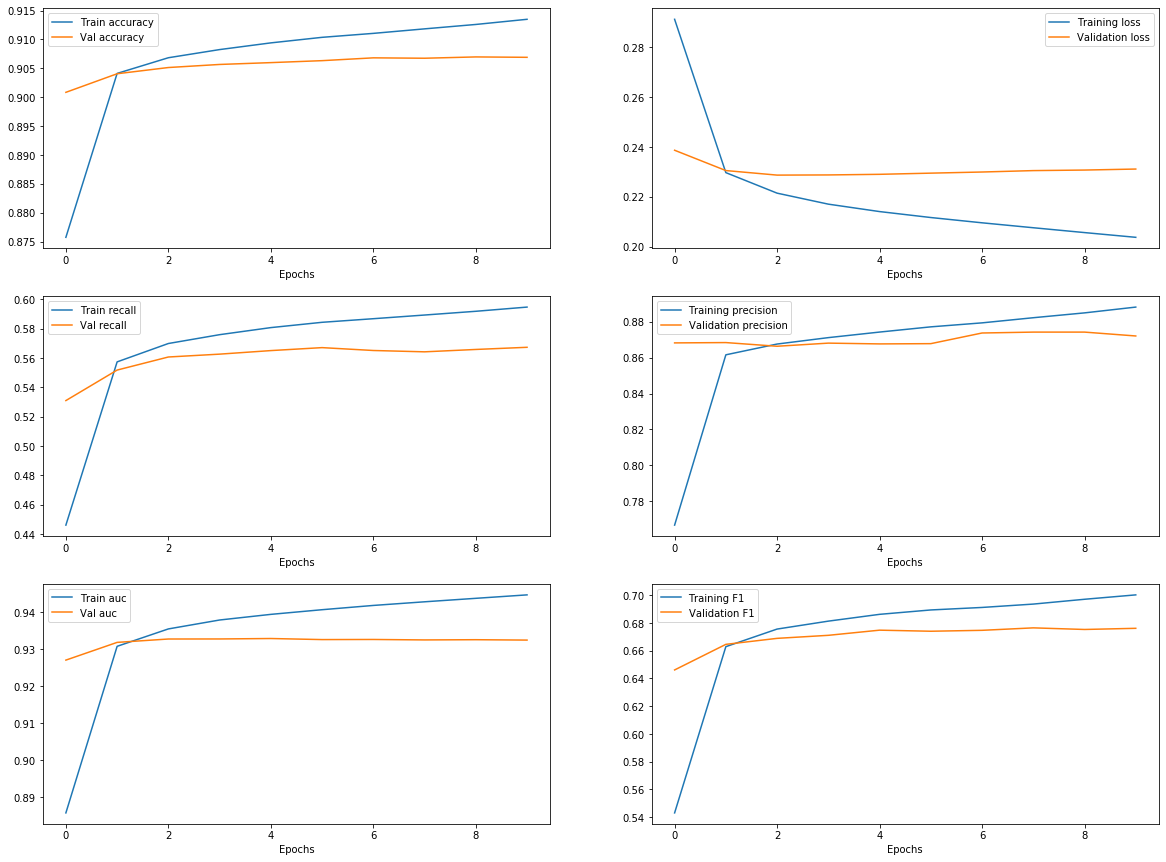

In [21]:
def  plot_train_history(history):
    fig, axes = plt.subplots(3, 2, figsize=(20, 15))

    axes[0][0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0][0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0][0].set_xlabel('Epochs')
    axes[0][0].legend() 

    axes[0][1].plot(history.history['loss'], label='Training loss')
    axes[0][1].plot(history.history['val_loss'], label='Validation loss')
    axes[0][1].set_xlabel('Epochs')
    axes[0][1].legend()
    
    axes[1][0].plot(history.history['recall'], label='Train recall')
    axes[1][0].plot(history.history['val_recall'], label='Val recall')
    axes[1][0].set_xlabel('Epochs')
    axes[1][0].legend() 

    axes[1][1].plot(history.history['precision'], label='Training precision')
    axes[1][1].plot(history.history['val_precision'], label='Validation precision')
    axes[1][1].set_xlabel('Epochs')
    axes[1][1].legend()
    
    axes[2][0].plot(history.history['auc'], label='Train auc')
    axes[2][0].plot(history.history['val_auc'], label='Val auc')
    axes[2][0].set_xlabel('Epochs')
    axes[2][0].legend() 

    axes[2][1].plot(history.history['f1_m'], label='Training F1')
    axes[2][1].plot(history.history['val_f1_m'], label='Validation F1')
    axes[2][1].set_xlabel('Epochs')
    axes[2][1].legend()


plot_train_history(history)

In [22]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=32)
x_test, y_true = next(test_gen)

y_pred = model.predict_on_batch(x_test)

# y_true = tf.math.argmax(y_test, axis=-1)
# y_pred = tf.math.argmax(y_pred, axis=-1)

In [24]:
for i in range(30):
    pred = y_pred[i].numpy()[0]
    gd = int2label[y_true[i]]
    print('%s, %.2f, %s' % (gd, pred, x_test[i]))

#     ax.set_title('pred: {}'.format(
#         ''.join(map(lambda i: int2label[i], y_pred[img_idx].numpy()))))
#     ax.set_xlabel('true: {}'.format(
#         ''.join(map(lambda i: b[i], y_true[img_idx].numpy()))))
#     ax.set_xticks([])
#     ax.set_yticks([])

bad, 1.00, 194.1.238.155/module/6fa68d441c87e67e6814956e0128376f/
good, 0.01, docstoc.com/docs/62494790/Tilley-Information
good, 0.00, ocoathletics.stadiumhotelnetwork.com/directions.html
good, 0.50, gardnerdenverproducts.com/Microsite_Product.aspx?id=4004&n=2156
bad, 0.26, toobatextile.com/doc/2016DocDriveInc/2016DocDriveInc/
good, 0.29, cka.byinter.net/ckgm.html
good, 0.00, yellowbot.com/browse/movie%20theater/Kansas%20City%2C%20MO/page4.html
good, 0.00, youtube.com/watch?v=LRrRbQKUue8
good, 0.00, war.wikia.com/wiki/World_War_II
good, 0.00, wn.com/San_Francisco_Bay_Area
good, 0.00, artinfo.com/artists/profile/217714/vladimir-kush/
good, 0.12, deeper-voice.com/an-exercise-to-make-your-voice-sound-deeper
good, 0.01, cbc.ca/news/canadavotes/ridings/montreal.html
good, 0.19, mcbw.org/mnservices
good, 0.00, best-cities.findthebest.com/d/d/North-Dakota
good, 0.10, facebook.com/sean.w.harrington
good, 0.05, home.earthlink.net/~glengreenbythesea/history.shtml
good, 0.00, linkedin.com/company